# Example: Extrinsic calibration of 15 GoPro cameras

Suppose we have 15 GoPro cameras capturing a target.  This example demonstrates how to calibrate these cameras into a unified world coordinate system.  The steps include:

1. Intrinsic calibration
2. 2D corresponding points detection
3. Extrinsic calibration
   1. Linear calibration (intial guess)
   2. Non-linear optimization (bundle adjustment)
4. (optional) Scale / orientation adjustment

## Step 4: Point detection for scale / orientation adjustment 

Suppose we capture an AruCo marker on the floor as shown below, and some cameras could detect the marker successfully.  The idea is to rotate and scale the world coordinate system so that the 3D plane of this marker is equal to the $z=0$ plane.

1. Triangulate the 3D position of each marker corner in the current world coordinate system.
2. Estimate the similarity transform between the triangulated four marker corners and their ideal positions on $z=0$ plane.
   - The four corners are supposed to be located at $(\pm s/2, \pm s/2, 0)$ where $s$ is the edge length of the marker specified by `SCALE` parameter.
3. Apply the similarity transform to the world coordinate system.

This is an optional step to make the calibration more interpretable.  It does not affect the accuracy of the calibration result.

![z-plane.jpg](../data/ba/floor.jpg)


### 4-1: Detection

The cell below detects the marker from each image.

 0, ../data/ba/floor/camera_01.jpg, marker=[[0]] (3011.8 2159.5) (2435.6 2179.1) (2448.7 1677.7) (2956.9 1662.1)


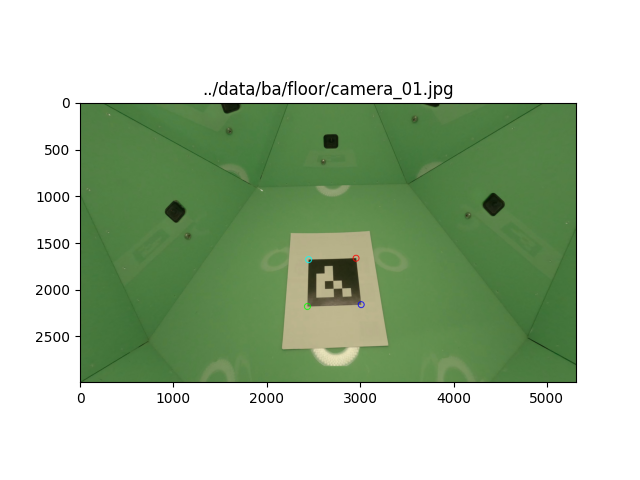

 1, ../data/ba/floor/camera_02.jpg, marker=[[0]] (3069.2 2741.7) (2264.9 2764.9) (2343.1 2306.6) (2953.3 2297.0)


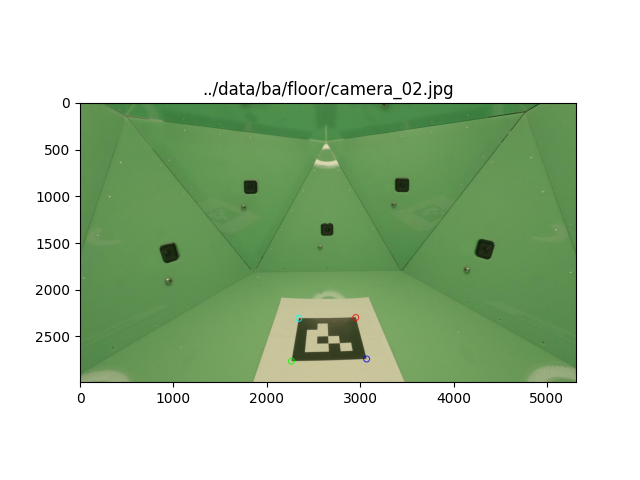

 2, ../data/ba/floor/camera_03.jpg, marker=None
 3, ../data/ba/floor/camera_04.jpg, marker=[[0]] (2451.2 2368.2) (2309.0 1861.9) (2799.0 1721.3) (2999.2 2187.1)


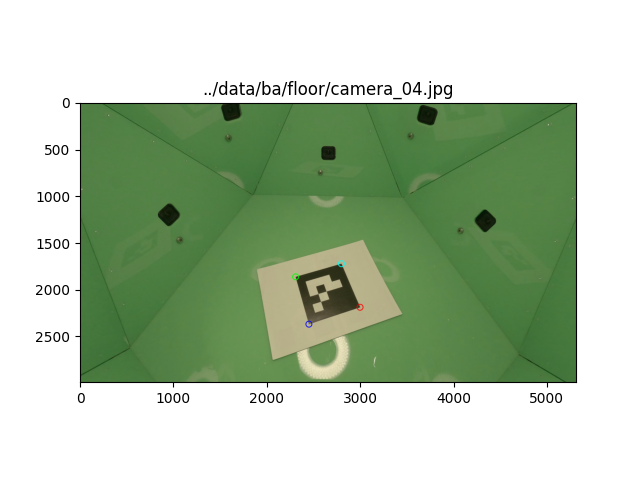

 4, ../data/ba/floor/camera_05.jpg, marker=[[0]] (2411.8 2849.1) (2253.3 2387.6) (2835.3 2254.1) (3142.8 2638.0)


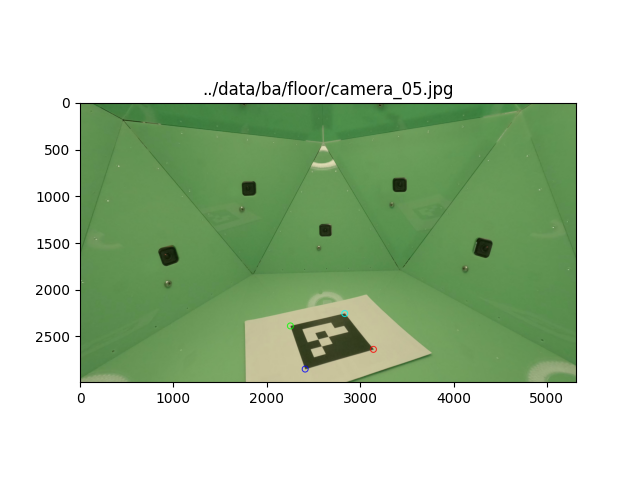

 5, ../data/ba/floor/camera_06.jpg, marker=None
 6, ../data/ba/floor/camera_07.jpg, marker=None
 7, ../data/ba/floor/camera_08.jpg, marker=[[0]] (2160.1 2482.8) (2689.8 2254.1) (3137.2 2551.0) (2558.4 2912.1)


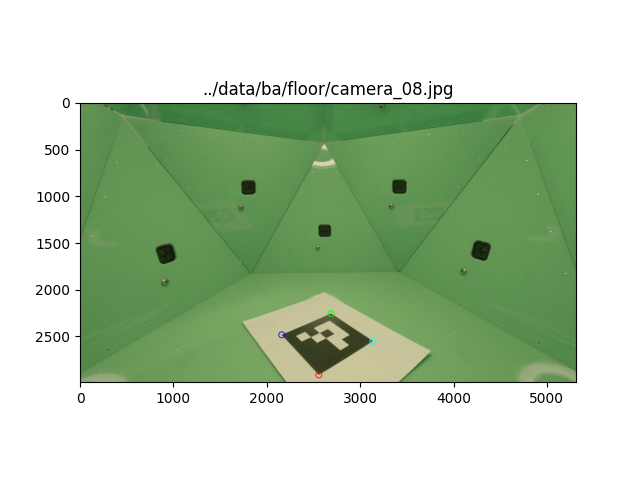

 8, ../data/ba/floor/camera_09.jpg, marker=None
 9, ../data/ba/floor/camera_10.jpg, marker=[[0]] (2572.0 1539.5) (3008.3 1788.0) (2722.1 2231.0) (2261.0 1927.4)


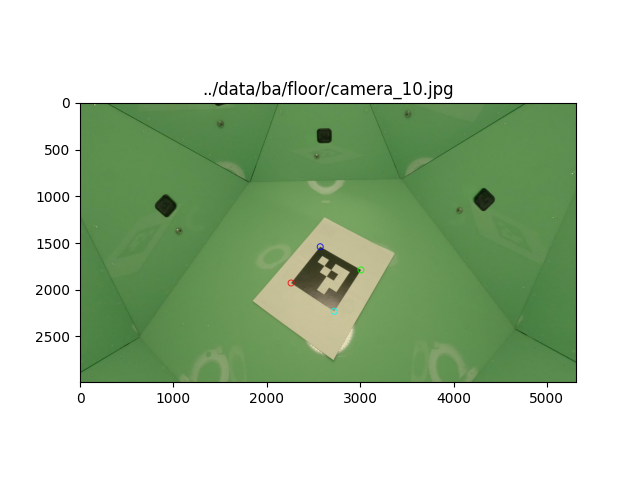

10, ../data/ba/floor/camera_11.jpg, marker=[[0]] (2582.1 2265.5) (3128.6 2466.7) (2773.4 2910.0) (2156.3 2594.5)


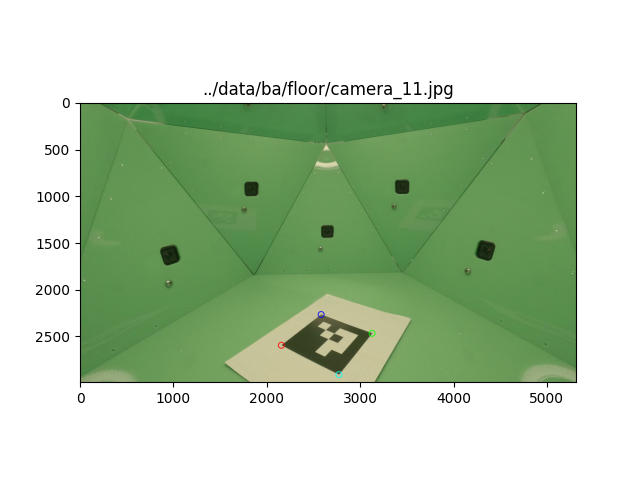

11, ../data/ba/floor/camera_12.jpg, marker=None
12, ../data/ba/floor/camera_13.jpg, marker=[[0]] (2961.1 1756.3) (2842.7 2258.6) (2290.6 2104.0) (2468.9 1638.0)


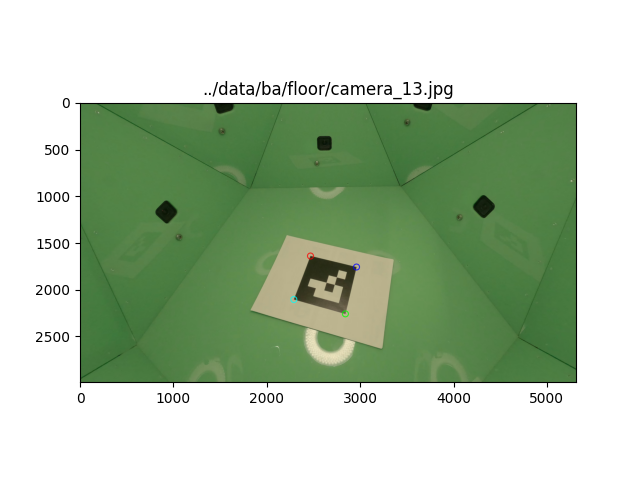

13, ../data/ba/floor/camera_14.jpg, marker=[[0]] (3068.7 2313.0) (2954.8 2777.0) (2208.2 2608.8) (2482.1 2218.9)


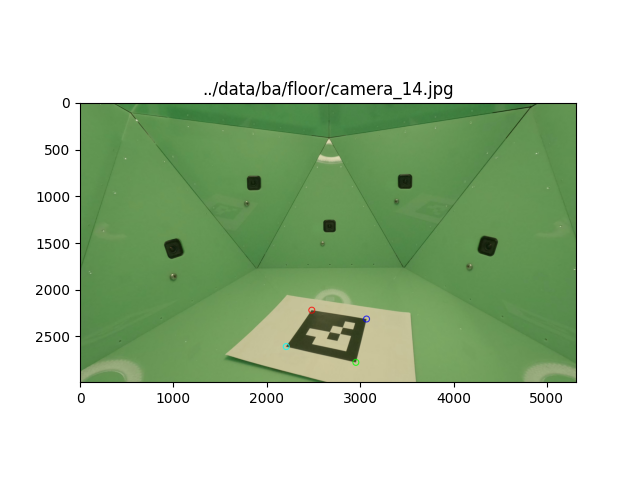

14, ../data/ba/floor/camera_15.jpg, marker=None


In [1]:
%matplotlib widget

import numpy as np
import sys
import os
import json
import bz2
import cv2
import matplotlib.pyplot as plt
import glob
import re
import pandas as pd
import pycalib  # pip install pycalib-simple

# [Input] image files
INPUT_FILES = '../data/ba/floor/*.jpg'

# [INPUT] calibration after the bundle adjustment = output of step 3
FILE_RESULT_BA = 'output-ba.json'

# [INPUT] scaling factor, the edge length of the marker
SCALE = 150

# [OUTPUT] detected corner points
FILE_FLOOR = 'output-floor.txt.bz2'

# [OUTPUT] final calibration result
FILE_RESULT = 'output.json'

# How to extract camera-id from an image filename 
def parse_filename(filename):
    # filename -> camera-id
    f = os.path.basename(filename)
    ret = re.match('camera_0*([0-9]+).((jpg)|(png))', f)
    if ret:
        return int(ret.group(1)) - 1
    else:
        return -1

# AruCo dictionary
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)

# Detector
parameters =  cv2.aruco.DetectorParameters()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_CONTOUR
detector = cv2.aruco.ArucoDetector(aruco_dict, detectorParams=parameters)

# Load the current calibration
camera_matrix, dist_coeffs, rmat, tvec, reproj = pycalib.util.load_calib(FILE_RESULT_BA)
Nc = len(camera_matrix)

camera_indices = []
point_indices = []
points_2d = []
marker_ids = []
images = []

for fname in sorted(glob.glob(INPUT_FILES)):
    i = parse_filename(fname)
    bgr = cv2.imread(fname)
    bgr = cv2.undistort(bgr, camera_matrix[i], dist_coeffs[i], None, camera_matrix[i])
    images.append(bgr.copy())

    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    # markers are detected in [tl, tr, br, bl] order
    corners, ids, rejected_points = detector.detectMarkers(gray)

    print( f'{i:2d}, {fname}, marker={ids}', end='' )

    if ids is None:
        print('')
        continue

    assert len(ids[0]) == 1

    marker_ids.append(ids[0][0])

    c = corners[0][0]
    for j in range(4):
        camera_indices.append(i)
        point_indices.append(j)
        points_2d.append(c[j])
        print( f' ({c[j][0]:.1f} {c[j][1]:.1f})', end='' )
    print('')

    color = [
        [255, 0, 0 ],
        [0, 255, 0 ],
        [255, 255, 0 ],
        [0, 0, 255 ],
    ]
    for j in range(4):
        cv2.circle(bgr, c[j].astype(np.int32), 32, color[j], thickness=8)

    plt.figure()
    plt.imshow(bgr[:,:,::-1])
    plt.title(fname)
    plt.show()

camera_indices = np.array(camera_indices)
point_indices = np.array(point_indices)
points_2d = np.array(points_2d)

# Save as BAL for debug
with bz2.open(FILE_FLOOR, 'wb') as fp:
    pycalib.bal.bal_write(fp, Nc, camera_indices=camera_indices, point_indices=point_indices, points_2d=points_2d)


### 4-2: Transform

This cell triangulates the four corners, and finds the similarity transform which aligns the triangulated four corners to their ideal posisions.  The final plot visualizes the floor by an orange plane.


15 cameras, 4 3D points, 36 observations

The four corners in WCS are
[[ 0.18574152 -0.25286652 -0.27071708  0.16805703]
 [ 0.46523988  0.47915724  0.11234555  0.10090678]
 [ 1.88359303  1.87337588  2.11215451  2.12537444]]


The four corners in WCS are
[[-7.62011730e+01  7.60125235e+01  7.64067519e+01 -7.62677515e+01]
 [ 7.60398285e+01  7.59324488e+01 -7.61423802e+01 -7.59181602e+01]
 [ 5.57298610e-01 -1.93735770e-02  5.19853957e-01 -3.15566322e-01]]



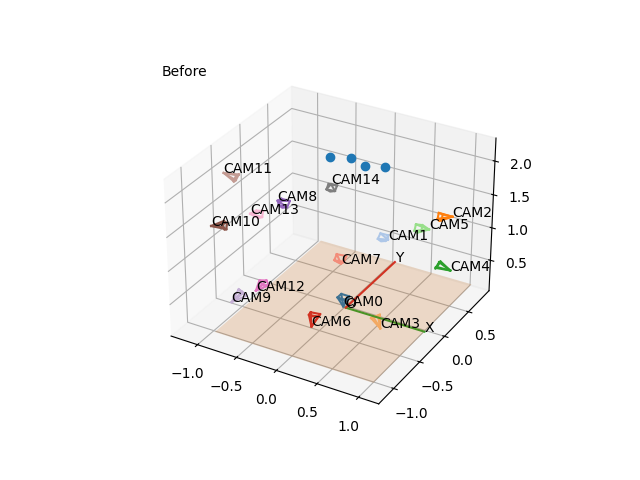

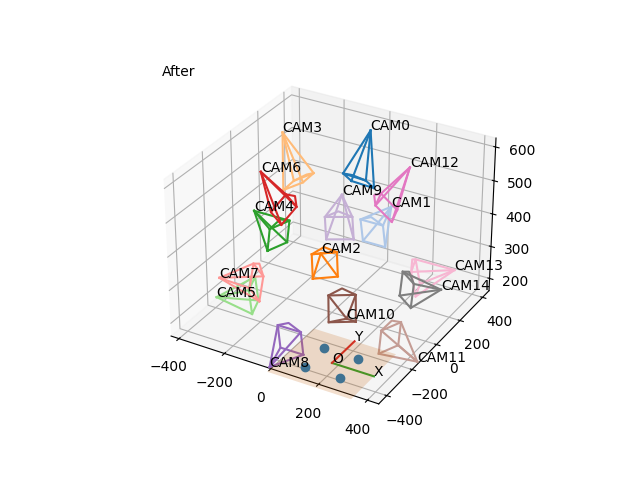

In [2]:
plt.close()

# Load the current calibration
camera_matrix, dist_coeffs, rmat, tvec, reproj = pycalib.util.load_calib(FILE_RESULT_BA)

# Load the observed AR marker corners
with bz2.open(FILE_FLOOR) as fp:
    camera_params, points_3d, camera_indices, point_indices, points_2d = pycalib.bal.bal_read(fp)
Nc = len(camera_params)
print(f'{Nc} cameras, {len(points_3d)} 3D points, {len(points_2d)} observations')

# Triangulate the 3D points
P = []
for i in range(Nc):
    P.append(camera_matrix[i] @ np.hstack((rmat[i], tvec[i])))
P = np.array(P)
Y, _ = pycalib.calib.triangulateN(camera_matrix, np.zeros(dist_coeffs.shape), P, camera_indices, point_indices, points_2d)
print(f'\nThe four corners in WCS are\n{Y}\n')

# Plot
camera_params = pycalib.ba.encode_camera_params(rmat, tvec, camera_matrix, dist_coeffs)
_ = pycalib.plot.plotCameras(camera_params, Y.T, scale=-1, title='Before', draw_zplane=True)


# Similarity transform
X = np.array( [
    [ -SCALE/2,  SCALE/2, 0 ], # TL
    [  SCALE/2,  SCALE/2, 0 ], # TR
    [  SCALE/2, -SCALE/2, 0 ], # BR
    [ -SCALE/2, -SCALE/2, 0 ], # BL
    ] ).T
R, t, s = pycalib.calib.absolute_orientation(Y, X)

# Transform the cameras
rmat2 = []
tvec2 = []
for r_w2c, t_w2c in zip (rmat, tvec):
    r_c2w = r_w2c.T
    t_c2w = - r_w2c.T @ t_w2c

    r_c2w = R @ r_c2w
    t_c2w = s * R @ t_c2w + t.reshape((3, 1))

    r_w2c = r_c2w.T
    t_w2c = - r_c2w.T @ t_c2w

    assert r_w2c.shape == (3, 3)
    assert t_w2c.shape == (3, 1)

    rmat2.append(r_w2c)
    tvec2.append(t_w2c)
rmat = np.array(rmat2)
tvec = np.array(tvec2)

# Save the result
pycalib.util.save_calib(FILE_RESULT, camera_matrix=camera_matrix, dist_coeffs=dist_coeffs, rmat=rmat, tvec=tvec, reproj=reproj)

# Triangulate again
P = []
for i in range(Nc):
    P.append(camera_matrix[i] @ np.hstack((rmat[i], tvec[i])))
P = np.array(P)
Y, _ = pycalib.calib.triangulateN(camera_matrix, np.zeros(dist_coeffs.shape), P, camera_indices, point_indices, points_2d)
print(f'\nThe four corners in WCS are\n{Y}\n')

# Plot
camera_params = pycalib.ba.encode_camera_params(rmat, tvec, camera_matrix, dist_coeffs)
_ = pycalib.plot.plotCameras(camera_params, Y.T, scale=50, title='After', draw_zplane=True)

